<a href="https://colab.research.google.com/github/sqhang/Gimmereceipt/blob/main/Bill_com.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bill.com Challenge

In [ ]:
!pip install paddleocr
!pip install paddlepaddle

In [170]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Generating OCR for images that does not come with them

In [ ]:
from paddleocr import PaddleOCR,draw_ocr

ocr = PaddleOCR(use_angle_cls=True, lang='en') # need to run only once to download and load model into memory

def generate_ocr_from_image(image_path):
  result = ocr.ocr(image_path, cls=True)
  txt_array = [line[1][0] for line in result[0]]
  txt_concat = " ".join(txt_array)
  return txt_concat

In [177]:
# Testing ocr on an image
ocr_text = generate_ocr_from_image('/content/drive/MyDrive/Datathon/img-20230128T024845Z-001/img/00d0100894168.jpg')

[2023/01/29 05:11:21] ppocr DEBUG: dt_boxes num : 77, elapse : 0.8403098583221436
[2023/01/29 05:11:21] ppocr DEBUG: cls num  : 77, elapse : 0.6223695278167725
[2023/01/29 05:11:28] ppocr DEBUG: rec_res num  : 77, elapse : 6.7411582469940186


In [178]:
import os
import pandas as pd

# Helper function to read content from ocr.csv file
def read_ocr_2_para(filepath, colnames = ['x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'x4', 'y4', 'text1', 'text2', 'text3']):
    df_test1 = pd.read_csv(filepath, names=colnames)

    df_test1['Text_merge'] = df_test1[df_test1.columns[8:]].apply(
        lambda x: ','.join(x.dropna().astype(str)),
        axis=1)
    
    out = ' '.join(df_test1['Text_merge'])

    return out

# Get all ocr files and cache it in a local dictionary
def get_all_ocr(img_path, ocr_path):
  all_ocr = {}

  all_img_paths = os.listdir(img_path)
  all_ocr_paths = os.listdir(ocr_path)
  for img in tqdm(all_img_paths):
    img_id = os.path.splitext(img)[0]
    img_corred_ocr_name = img_id + '.csv'
    ocr_file_path = ocr_path + '/' + img_corred_ocr_name
    img_file_path = img_path + '/' + img
    if img_corred_ocr_name in all_ocr_paths:
      try:
        all_ocr[img_id] = read_ocr_2_para(ocr_file_path)
      except:
        all_ocr[img_id] = generate_ocr_from_image(img_file_path)
    else:
      all_ocr[img_id] = generate_ocr_from_image(img_file_path)
  return all_ocr

In [ ]:
all_ocr = get_all_ocr('/content/drive/MyDrive/Datathon/img-20230128T024845Z-001/img/', '/content/drive/MyDrive/Datathon/ocr-20230128T024910Z-001/ocr/')

## Split ocrs into training set and validation set

In [183]:
train_transactions_csv = pd.read_csv('/content/drive/MyDrive/Datathon/Users.csv')
test_transactions_csv = pd.read_csv('/content/drive/MyDrive/Datathon/test_transactions.csv')

In [184]:
test_doc_id = []
for i in range(len(test_transactions_csv)):
  user_row = test_transactions_csv.iloc[i]
  documentid = user_row['documentid']
  test_doc_id.append(documentid)

In [185]:
train_doc_id = []
for i in range(len(train_transactions_csv)):
  user_row = train_transactions_csv.iloc[i]
  documentid = user_row['documentid']
  train_doc_id.append(documentid)

In [187]:
train_data = {}
test_data = {}

for documentid in test_doc_id:
  test_data[documentid] = all_ocr[documentid]

for documentid in train_doc_id:
  train_data[documentid] = all_ocr[documentid]

## Store ocrs as a json object for later reuse

In [188]:
import json

with open('test_data.json', 'w') as fp:
    json.dump(test_data, fp)

with open('train_data.json', 'w') as fp:
    json.dump(train_data, fp)

## Get a glimpse on what user.csv looks like

In [ ]:
users = pd.read_csv("/content/drive/MyDrive/Datathon/Users.csv")
users

# Feature Engineering
Design four distinctive similarity measures (date, transaction amount, vendor name, vendor address) between the ocr text output and a row of user transaction data.

## Date

In [189]:
from dateutil.parser import parse

# helper function to parse string into a datetime object
def parse_date(string, fuzzy=False):
    try:
        date = parse(string, fuzzy = fuzzy)
        return date

    except ValueError:
        return None
    
    except OverflowError:
        return None

# list all the potential datetime objects within a ocr text
def list_potential_date(para):
    date_list = []
    token_list = para.split(" ")
    # print(len(token_list))
   
    for token in token_list:
        date = parse_date(token)
        if date != None:
            if (("/" in token) or ('-' in token)) and token[0] != '-':
                date_list.append(date)

    if len(date_list) == 0:
        for i in range(len(token_list) - 2):
            cur_string = token_list[i] + " " + token_list[i+1] + " " + token_list[i+2]
            date = parse_date(cur_string, True)
            if date != None:
                date_list.append(date)
    if (len(date_list) == 0):
        print(token_list)
        print("Still not found!")
    return date_list


In [190]:
# compare two datetime objects
def compareDates(date1, date2):
    if date1.year == date2.year and date1.month == date2.month and date1.day == date2.day:
        return True
    if date1.year == date2.year and date1.month == date2.day and date1.day == date2.month:
        return True
    return False

def eval_date(date_string, datetime_list):
    date = parse_date(date_string)
    if date == None:
        return 0
    else:
        for datetime in datetime_list:
            if compareDates(date, datetime):
                return 1
        return 0

## Amount

In [191]:
import re

def eval_amount(to_find, source):
  if str(to_find) in source:
  #if re.search(to_find, source) != None:
    return 1
  else:
    return 0

## Vendor Name

In [ ]:
def eval_vendname(to_find, source):
  to_find = to_find.lower()
  source = source.lower()

  tokens = to_find.split()
  score = 0
  for token in tokens:
    if token in source:
      score += 1
  return score / len(tokens)

## Vendor Address

In [ ]:
def eval_address_score(to_find, source):
  to_find = to_find.lower()
  source = source.lower()

  tokens = to_find.split()
  score = 0
  for token in tokens:
    if token in source:
      score += 1
  return score / len(tokens)

In [ ]:
# load train
train_f_large = open('/content/drive/MyDrive/Datathon/train_data_large.json')
test_f_large = open('/content/drive/MyDrive/Datathon/test_data.json')
# returns JSON object as 
# a dictionary
train_ocr_large = json.load(train_f_large)
test_ocr = json.load(test_f_large)
print(train_ocr_large)
print(len(train_ocr_large))

In [ ]:
# load train small
train_f_small = open('/content/drive/MyDrive/Datathon/train_data_small.json')
  
# returns JSON object as 
# a dictionary
train_ocr_small = json.load(train_f_small)
print(train_ocr_small)
print(len(train_ocr_small))

In [28]:
data = []
for k, v in train_ocr_small.items():
    row = {}
    row["documentid_ocr"] = k
    row["ocr_text"] = v
    data.append(row)

# data = [{k: v} for k,v in train_ocr_small.items()]
ocr_small_df = pd.DataFrame(data)

In [193]:
train_user_df = pd.read_csv("/content/drive/MyDrive/Datathon/Users.csv")
train_small_df = ocr_small_df.merge(train_user_df, how='cross')
train_small_df["truth"] = (train_small_df["documentid_ocr"] == train_small_df["documentid"]) 
train_small_df["truth"] = train_small_df["truth"].astype(int)

## Prepare training data points

In [194]:
train_small_df["eval_amount"] = train_small_df.apply(lambda row: eval_amount(row["amount"], row["ocr_text"]), axis = 1)
train_small_df["eval_amount"].sum()

6338

In [195]:
train_small_df["eval_vendname"] = train_small_df.apply(lambda row: eval_vendname(row["vendor_name"], row["ocr_text"]), axis = 1)
train_small_df["eval_vendname"].sum()

48761.44365079365

In [196]:
train_small_df["eval_address"] = train_small_df.apply(lambda row: eval_address_score(row["vendor_address"], row["ocr_text"]), axis = 1)
train_small_df["eval_address"].sum()

43278.69281644568

In [197]:
datetime_dict = {}
for docID, ocrTxt in train_ocr_small.items():
    datetime_dict[docID] = list_potential_date(ocrTxt)

len(datetime_dict)

499

In [198]:
train_small_df["eval_date"] = train_small_df.apply(lambda row: eval_date(row['date'], datetime_dict[row['documentid_ocr']]), axis = 1)
train_small_df['eval_date'].sum()

1220

In [199]:
data = train_small_df.to_numpy()

In [204]:
y = data[:,-5]
X = data[:, -4:]
y = y.astype(int)

## Split training and validation data

In [205]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 42)

## Logistic Regression Classifier

Predicted Probablity: 
[[9.76882547e-01 2.31174533e-02]
 [9.99508780e-01 4.91220164e-04]]
Coefficients: 


array([[2.83490887, 2.11883454, 5.19327531, 5.50898372]])

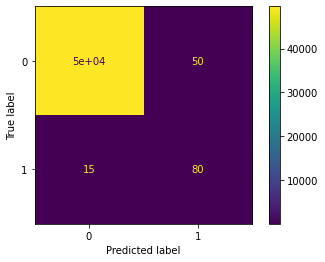

In [256]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

clf = LogisticRegression(random_state=0, class_weight={0: 1/10, 1: 9/10}).fit(X_train, y_train)
y_pred = clf.predict(X_val)
cm = confusion_matrix(y_val, y_pred)

disp = ConfusionMatrixDisplay(cm)
disp.plot()

print("Predicted Probablity: ")
print(clf.predict_proba(X[:2, :]))
print("Coefficients: ")
clf.coef_

In [257]:
from sklearn.metrics import precision_recall_fscore_support
precision, recall, fbetascore, support = precision_recall_fscore_support(y_val, y_pred, average = "binary")
precision, recall, fbetascore, support

(0.6153846153846154, 0.8421052631578947, 0.7111111111111111, None)

In [251]:
clf = LogisticRegression(random_state=2, class_weight={0: 1/10, 1: 9/10}).fit(X, y)

ROC AUC score

In [218]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_val, clf.predict_proba(X_val)[:, 1])

0.9968236387855326

## XGBoost Classifier

[[9.9609685e-01 3.9031673e-03]
 [9.9997324e-01 2.6779520e-05]]


0.9993172827854863

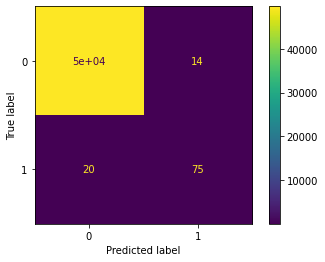

In [254]:
from xgboost import XGBClassifier

clf2 = XGBClassifier(max_depth = 4, rand_state = 2).fit(X_train, y_train)

     
y_pred = clf2.predict(X_val)
cm = confusion_matrix(y_val, y_pred)

disp = ConfusionMatrixDisplay(cm)
disp.plot()

print(clf2.predict_proba(X[:2, :]))
clf2.score(X_val, y_val)

Precision and Recall

In [255]:
from sklearn.metrics import precision_recall_fscore_support
precision, recall, fbetascore, support = precision_recall_fscore_support(y_val, y_pred, average = "binary")
precision, recall, fbetascore, support

(0.8426966292134831, 0.7894736842105263, 0.8152173913043478, None)

ROC AUC Score

In [222]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_val, clf.predict_proba(X_val)[:, 1])

0.9968236387855326

In [249]:
clf2 = XGBClassifier(max_depth = 4, rand_state = 2).fit(X, y)

### Accuracy Criteria
Given a set of ocr outputs, and a table of user transactions,  we predict a row from the user transaction data to be the source for each ocr output. We calculate accuracy by dividing number of predictions equal to ground truth by total number of predictions

## Algorithm 1 
Compute similarity measure and pick the row with the highest similarity measure. This similarity measured is a linear combination of the four previous engineered features.

In [226]:
p1 = 1
p2 = 2 
p3 = 1 
p4 = 1 

# Compute similarity measure and pick the row with the highest similarity measure
def voteAlgo(user_rows, ocr_text):  
  all_scores = []
  datetimelist = list_potential_date(ocr_text)

  for i in range(len(user_rows)):
      user_row = user_rows.iloc[i]
      amount = user_row['amount']
      date = user_row['date']
      vendor_name = user_row['vendor_name']
      vendor_address = user_row['vendor_address']
      
      amount_score = eval_amount(amount, ocr_text)
      date_score = eval_date(date, datetimelist)
      vendor_name_score = eval_vendname(vendor_name, ocr_text)
      vendor_address_score = eval_address_score(vendor_address, ocr_text)

      total_score = p1 * amount_score + p2 * date_score + p3 * vendor_name_score + p4 * vendor_address_score
      all_scores.append(total_score)
  predict_row_idx = all_scores.index(max(all_scores))
  return predict_row_idx

def myAlgo(docID, ocrDict):
  ocrTxt = ocrDict[docID] 
  return voteAlgo(user_rows, ocrTxt)





## Performance on validation dataset

In [227]:
import numpy as np
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

user_rows = pd.read_csv('/content/drive/MyDrive/Datathon/Users.csv')
filestem = "/content/drive/MyDrive/Datathon/ocr-20230128T024910Z-001/ocr/"
ordered_documentid_array = np.array(user_rows["documentid"])
correct_predicted_array = np.arange(0, 499, 1)

def predict(pred_func, correct_predicted_array, all_ocr):
    predicted_array = np.zeros(correct_predicted_array.size)
    for idx in tqdm(range(ordered_documentid_array.size)):
        predicted_array[idx] = pred_func(ordered_documentid_array[idx], all_ocr)

    num_correct_choices = (predicted_array == correct_predicted_array).sum()
    assert (predicted_array.size == correct_predicted_array.size)
    print(num_correct_choices)
    print("Accuracy of the given model is {0} ".format(num_correct_choices / predicted_array.size))
    result = {ordered_documentid_array[i]: (predicted_array[i], correct_predicted_array[i]) for i in range(len(ordered_documentid_array))}
    return num_correct_choices / predicted_array.size, result

print(predict(myAlgo, correct_predicted_array, train_ocr_small))

100%|██████████| 499/499 [01:13<00:00,  6.75it/s]

436
Accuracy of the given model is 0.87374749498998 
(0.87374749498998, {'00d0624439175': (120.0, 0), '00d0654270874': (1.0, 1), '00d0403711886': (2.0, 2), '00d0956164753': (3.0, 3), '00d0667839698': (37.0, 4), '00d0841246769': (5.0, 5), '00d0414196980': (6.0, 6), '00d0726523245': (7.0, 7), '00d0320587587': (8.0, 8), '00d0333208815': (9.0, 9), '00d0330533884': (10.0, 10), '00d0694627982': (11.0, 11), '00d0408017404': (12.0, 12), '00d0447521528': (13.0, 13), '00d0194076657': (14.0, 14), '00d0546591203': (15.0, 15), '00d0116292534': (16.0, 16), '00d0796308197': (17.0, 17), '00d0992127574': (18.0, 18), '00d0961798581': (19.0, 19), '00d0267909555': (20.0, 20), '00d0973462000': (21.0, 21), '00d0280864237': (22.0, 22), '00d0697219524': (23.0, 23), '00d0145695018': (24.0, 24), '00d0330285744': (25.0, 25), '00d0477960526': (26.0, 26), '00d0955195431': (27.0, 27), '00d0167381962': (28.0, 28), '00d0614628355': (29.0, 29), '00d0761346037': (30.0, 30), '00d0502129574': (31.0, 31), '00d0686078737':

## Performance on test set

In [232]:
import numpy as np
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

user_rows = pd.read_csv('/content/drive/MyDrive/Datathon/test_transactions.csv')
filestem = "/content/drive/MyDrive/Datathon/ocr-20230128T024910Z-001/ocr/"
ordered_documentid_array = np.array(user_rows["documentid"])
correct_predicted_array = np.arange(0, 126, 1)

def predict(pred_func, correct_predicted_array, all_ocr):
    predicted_array = np.zeros(correct_predicted_array.size)
    for idx in tqdm(range(ordered_documentid_array.size)):
        predicted_array[idx] = pred_func(ordered_documentid_array[idx], all_ocr)

    num_correct_choices = (predicted_array == correct_predicted_array).sum()

    assert (predicted_array.size == correct_predicted_array.size)
    print(num_correct_choices)
    print("Accuracy of the given model is {0} ".format(num_correct_choices / predicted_array.size))
    result = {ordered_documentid_array[i]: (predicted_array[i], correct_predicted_array[i]) for i in range(len(ordered_documentid_array))}
    return num_correct_choices / predicted_array.size, result

print(predict(myAlgo, correct_predicted_array, test_ocr))

100%|██████████| 126/126 [00:04<00:00, 26.59it/s]


118
Accuracy of the given model is 0.9365079365079365 
(0.9365079365079365, {'00d0472780579': (0.0, 0), '00d0269258457': (31.0, 1), '00d0145054354': (2.0, 2), '00d0795468800': (3.0, 3), '00d0682248746': (4.0, 4), '00d0471112949': (5.0, 5), '00d0472591457': (6.0, 6), '00d0354593861': (7.0, 7), '00d0179226173': (8.0, 8), '00d0277307035': (9.0, 9), '00d0902256238': (10.0, 10), '00d0230547657': (11.0, 11), '00d0859401532': (12.0, 12), '00d0343958098': (13.0, 13), '00d0676711962': (14.0, 14), '00d0114666542': (35.0, 15), '00d0507143553': (16.0, 16), '00d0622420051': (109.0, 17), '00d0831446713': (18.0, 18), '00d0472127340': (19.0, 19), '00d0164203891': (20.0, 20), '00d0343123955': (21.0, 21), '00d0714317145': (22.0, 22), '00d0443302756': (23.0, 23), '00d0484705589': (24.0, 24), '00d0415751725': (25.0, 25), '00d0726056883': (18.0, 26), '00d0916006350': (27.0, 27), '00d0660852423': (28.0, 28), '00d0811301203': (25.0, 29), '00d0741622526': (30.0, 30), '00d0204688228': (31.0, 31), '00d011521491

## Algorithm 2 Logistic Regression
Use logistic regression to predict a probability of having a match between the given ocr text and the row in transaction data. Pick the row with highest probability as prediction result.

In [233]:
def voteAlgo2(user_rows, ocr_text):
    all_scores = []
    datetimelist = list_potential_date(ocr_text)

    for i in range(len(user_rows)):
        user_row = user_rows.iloc[i]
        amount = user_row['amount']
        date = user_row['date']
        vendor_name = user_row['vendor_name']
        vendor_address = user_row['vendor_address']
        
        amount_score = eval_amount(amount, ocr_text)
        date_score = eval_date(date, datetimelist)
        vendor_name_score = eval_vendname(vendor_name, ocr_text)
        vendor_address_score = eval_address_score(vendor_address, ocr_text)
        result = clf.predict_proba(np.array([amount_score, vendor_name_score, vendor_address_score, date_score]).reshape(1, -1))
        result = np.array(result)
        total_score = result[0][1]
        
        all_scores.append(total_score)
    predict_row_idx = all_scores.index(max(all_scores))
    return predict_row_idx

def myAlgo2(docID, ocrDict):
  ocrTxt = ocrDict[docID] 
  return voteAlgo2(user_rows, ocrTxt)

## Performance on validation dataset

In [ ]:
import numpy as np
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

user_rows = pd.read_csv('/content/drive/MyDrive/Datathon/Users.csv')
filestem = "/content/drive/MyDrive/Datathon/ocr-20230128T024910Z-001/ocr/"
ordered_documentid_array = np.array(user_rows["documentid"])
correct_predicted_array = np.arange(0, 499, 1)

def predict(pred_func, correct_predicted_array, all_ocr):
    predicted_array = np.zeros(correct_predicted_array.size)
    for idx in tqdm(range(ordered_documentid_array.size)):
        predicted_array[idx] = pred_func(ordered_documentid_array[idx], all_ocr)

    num_correct_choices = (predicted_array == correct_predicted_array).sum()
    assert (predicted_array.size == correct_predicted_array.size)
    print(num_correct_choices)
    print("Accuracy of the given model is {0} ".format(num_correct_choices / predicted_array.size))
    result = {ordered_documentid_array[i]: (predicted_array[i], correct_predicted_array[i]) for i in range(len(ordered_documentid_array))}
    return num_correct_choices / predicted_array.size, result

print(predict(myAlgo2, correct_predicted_array, train_ocr_small))

100%|██████████| 499/499 [02:10<00:00,  3.84it/s]

442
Accuracy of the given model is 0.8857715430861723 
(0.8857715430861723, {'00d0624439175': (120.0, 0), '00d0654270874': (1.0, 1), '00d0403711886': (2.0, 2), '00d0956164753': (3.0, 3), '00d0667839698': (311.0, 4), '00d0841246769': (5.0, 5), '00d0414196980': (6.0, 6), '00d0726523245': (7.0, 7), '00d0320587587': (8.0, 8), '00d0333208815': (9.0, 9), '00d0330533884': (10.0, 10), '00d0694627982': (11.0, 11), '00d0408017404': (12.0, 12), '00d0447521528': (13.0, 13), '00d0194076657': (14.0, 14), '00d0546591203': (15.0, 15), '00d0116292534': (16.0, 16), '00d0796308197': (17.0, 17), '00d0992127574': (18.0, 18), '00d0961798581': (19.0, 19), '00d0267909555': (20.0, 20), '00d0973462000': (21.0, 21), '00d0280864237': (22.0, 22), '00d0697219524': (23.0, 23), '00d0145695018': (24.0, 24), '00d0330285744': (25.0, 25), '00d0477960526': (26.0, 26), '00d0955195431': (27.0, 27), '00d0167381962': (28.0, 28), '00d0614628355': (29.0, 29), '00d0761346037': (30.0, 30), '00d0502129574': (31.0, 31), '00d0686078

## Performance on test set

In [253]:
import numpy as np
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

user_rows = pd.read_csv('/content/drive/MyDrive/Datathon/test_transactions.csv')
filestem = "/content/drive/MyDrive/Datathon/ocr-20230128T024910Z-001/ocr/"
ordered_documentid_array = np.array(user_rows["documentid"])
correct_predicted_array = np.arange(0, 126, 1)

def predict(pred_func, correct_predicted_array, all_ocr):
    predicted_array = np.zeros(correct_predicted_array.size)
    for idx in tqdm(range(ordered_documentid_array.size)):
        predicted_array[idx] = pred_func(ordered_documentid_array[idx], all_ocr)

    num_correct_choices = (predicted_array == correct_predicted_array).sum()
    assert (predicted_array.size == correct_predicted_array.size)
    print(num_correct_choices)
    print("Accuracy of the given model is {0} ".format(num_correct_choices / predicted_array.size))
    result = {ordered_documentid_array[i]: (predicted_array[i], correct_predicted_array[i]) for i in range(len(ordered_documentid_array))}
    return num_correct_choices / predicted_array.size, result

print(predict(myAlgo2, correct_predicted_array, test_ocr))

100%|██████████| 126/126 [00:08<00:00, 14.04it/s]

120
Accuracy of the given model is 0.9523809523809523 
(0.9523809523809523, {'00d0472780579': (0.0, 0), '00d0269258457': (31.0, 1), '00d0145054354': (2.0, 2), '00d0795468800': (3.0, 3), '00d0682248746': (4.0, 4), '00d0471112949': (5.0, 5), '00d0472591457': (6.0, 6), '00d0354593861': (7.0, 7), '00d0179226173': (8.0, 8), '00d0277307035': (9.0, 9), '00d0902256238': (10.0, 10), '00d0230547657': (11.0, 11), '00d0859401532': (12.0, 12), '00d0343958098': (13.0, 13), '00d0676711962': (14.0, 14), '00d0114666542': (35.0, 15), '00d0507143553': (16.0, 16), '00d0622420051': (17.0, 17), '00d0831446713': (18.0, 18), '00d0472127340': (19.0, 19), '00d0164203891': (20.0, 20), '00d0343123955': (21.0, 21), '00d0714317145': (22.0, 22), '00d0443302756': (23.0, 23), '00d0484705589': (24.0, 24), '00d0415751725': (25.0, 25), '00d0726056883': (18.0, 26), '00d0916006350': (27.0, 27), '00d0660852423': (28.0, 28), '00d0811301203': (29.0, 29), '00d0741622526': (30.0, 30), '00d0204688228': (31.0, 31), '00d0115214912

## Algorithm 3 XGBoost Classifier

Use XGboost classifier (a gradient boosted ensemble method) to predict a probability of having a match between the given ocr text and the row in transaction data. Pick the row with highest probability as prediction result.

In [246]:
def voteAlgo3(user_rows, ocr_text):
    all_scores = []
    datetimelist = list_potential_date(ocr_text)

    for i in range(len(user_rows)):
        user_row = user_rows.iloc[i]
        amount = user_row['amount']
        date = user_row['date']
        vendor_name = user_row['vendor_name']
        vendor_address = user_row['vendor_address']
        
        amount_score = eval_amount(amount, ocr_text)
        date_score = eval_date(date, datetimelist)
        vendor_name_score = eval_vendname(vendor_name, ocr_text)
        vendor_address_score = eval_address_score(vendor_address, ocr_text)
        result = clf2.predict_proba(np.array([amount_score, vendor_name_score, vendor_address_score, date_score]).reshape(1, -1))
        result = np.array(result)
        total_score = result[0][1]
        
        all_scores.append(total_score)
    predict_row_idx = all_scores.index(max(all_scores))
    return predict_row_idx

def myAlgo3(docID, ocrDict):
  ocrTxt = ocrDict[docID] 
  return voteAlgo3(user_rows, ocrTxt)

## Performance on validation dataset

In [252]:
import numpy as np
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

user_rows = pd.read_csv('/content/drive/MyDrive/Datathon/Users.csv')
filestem = "/content/drive/MyDrive/Datathon/ocr-20230128T024910Z-001/ocr/"
ordered_documentid_array = np.array(user_rows["documentid"])
correct_predicted_array = np.arange(0, 499, 1)

def predict(pred_func, correct_predicted_array, all_ocr):
    predicted_array = np.zeros(correct_predicted_array.size)
    for idx in tqdm(range(ordered_documentid_array.size)):
        predicted_array[idx] = pred_func(ordered_documentid_array[idx], all_ocr)

    num_correct_choices = (predicted_array == correct_predicted_array).sum()
    assert (predicted_array.size == correct_predicted_array.size)
    print(num_correct_choices)
    print("Accuracy of the given model is {0} ".format(num_correct_choices / predicted_array.size))
    result = {ordered_documentid_array[i]: (predicted_array[i], correct_predicted_array[i]) for i in range(len(ordered_documentid_array))}
    return num_correct_choices / predicted_array.size, result

print(predict(myAlgo3, correct_predicted_array, train_ocr_small))

100%|██████████| 499/499 [01:53<00:00,  4.38it/s]

457
Accuracy of the given model is 0.9158316633266533 
(0.9158316633266533, {'00d0624439175': (120.0, 0), '00d0654270874': (1.0, 1), '00d0403711886': (2.0, 2), '00d0956164753': (3.0, 3), '00d0667839698': (234.0, 4), '00d0841246769': (5.0, 5), '00d0414196980': (6.0, 6), '00d0726523245': (7.0, 7), '00d0320587587': (8.0, 8), '00d0333208815': (9.0, 9), '00d0330533884': (10.0, 10), '00d0694627982': (11.0, 11), '00d0408017404': (12.0, 12), '00d0447521528': (13.0, 13), '00d0194076657': (40.0, 14), '00d0546591203': (15.0, 15), '00d0116292534': (16.0, 16), '00d0796308197': (17.0, 17), '00d0992127574': (18.0, 18), '00d0961798581': (19.0, 19), '00d0267909555': (20.0, 20), '00d0973462000': (21.0, 21), '00d0280864237': (22.0, 22), '00d0697219524': (23.0, 23), '00d0145695018': (24.0, 24), '00d0330285744': (25.0, 25), '00d0477960526': (26.0, 26), '00d0955195431': (27.0, 27), '00d0167381962': (28.0, 28), '00d0614628355': (29.0, 29), '00d0761346037': (30.0, 30), '00d0502129574': (31.0, 31), '00d0686078

## Performance on test set

In [250]:
import numpy as np
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

user_rows = pd.read_csv('/content/drive/MyDrive/Datathon/test_transactions.csv')
filestem = "/content/drive/MyDrive/Datathon/ocr-20230128T024910Z-001/ocr/"
ordered_documentid_array = np.array(user_rows["documentid"])
correct_predicted_array = np.arange(0, 126, 1)

def predict(pred_func, correct_predicted_array, all_ocr):
    predicted_array = np.zeros(correct_predicted_array.size)
    for idx in tqdm(range(ordered_documentid_array.size)):
        predicted_array[idx] = pred_func(ordered_documentid_array[idx], all_ocr)

    num_correct_choices = (predicted_array == correct_predicted_array).sum()

    assert (predicted_array.size == correct_predicted_array.size)
    print(num_correct_choices)
    print("Accuracy of the given model is {0} ".format(num_correct_choices / predicted_array.size))
    result = {ordered_documentid_array[i]: (predicted_array[i], correct_predicted_array[i]) for i in range(len(ordered_documentid_array))}
    return num_correct_choices / predicted_array.size, result

print(predict(myAlgo3, correct_predicted_array, all_ocr))

100%|██████████| 126/126 [00:09<00:00, 13.78it/s]

121
Accuracy of the given model is 0.9603174603174603 
(0.9603174603174603, {'00d0472780579': (0.0, 0), '00d0269258457': (102.0, 1), '00d0145054354': (2.0, 2), '00d0795468800': (3.0, 3), '00d0682248746': (4.0, 4), '00d0471112949': (5.0, 5), '00d0472591457': (6.0, 6), '00d0354593861': (7.0, 7), '00d0179226173': (8.0, 8), '00d0277307035': (9.0, 9), '00d0902256238': (10.0, 10), '00d0230547657': (11.0, 11), '00d0859401532': (12.0, 12), '00d0343958098': (13.0, 13), '00d0676711962': (14.0, 14), '00d0114666542': (35.0, 15), '00d0507143553': (16.0, 16), '00d0622420051': (17.0, 17), '00d0831446713': (18.0, 18), '00d0472127340': (19.0, 19), '00d0164203891': (20.0, 20), '00d0343123955': (21.0, 21), '00d0714317145': (22.0, 22), '00d0443302756': (23.0, 23), '00d0484705589': (24.0, 24), '00d0415751725': (25.0, 25), '00d0726056883': (33.0, 26), '00d0916006350': (27.0, 27), '00d0660852423': (28.0, 28), '00d0811301203': (29.0, 29), '00d0741622526': (30.0, 30), '00d0204688228': (31.0, 31), '00d011521491